## Model evaluation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models

%matplotlib inline

In [2]:
plt.style.use('ggplot')

### Helper functions

In [3]:
def pred_vs_actual_df(y_test, y_pred):
    """
    Function to plot predicted vs. actual emotion labels
    """
    # Emotion map
    label2name = {0:'neutral', 1:'calm', 2:'happy', 3:'sad',
                  4:'angry', 5:'fear', 6:'disgust', 7:'surprise'}
    
    df_pred = pd.DataFrame(columns=['predicted_label', 'actual_label'])
    df_pred['predicted_label'] = y_pred.flatten()
    df_pred['actual_label'] = y_test.flatten()
    df_pred['predicted_label'] = df_pred['predicted_label'].map(label2name)
    df_pred['actual_label'] = df_pred['actual_label'].map(label2name)
    
    return df_pred

In [4]:
def plot_confusion_matrix(y_test, y_pred):
    """
    Function to plot confusion matrix
    """
    cm = confusion_matrix(y_test, y_pred)
   
    # Emotion map
    label2name = {0:'neutral', 1:'calm', 2:'happy', 3:'sad',
                  4:'angry', 5:'fear', 6:'disgust', 7:'surprise'}
    
    # Add emotion annotation
    emotion_names = [emotion for emotion in label2name.values()]
    cm_df = pd.DataFrame(cm, index=emotion_names, columns=emotion_names)

    plt.figure(figsize=(6,5))
    sns.heatmap(cm_df, annot=True, cmap='Blues', linewidth=1, fmt='')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label'); 

### Load model and weights

In [5]:
# Create a new model
new_model = models.Sequential()

In [6]:
# Load model and weights
with open('CNN_multfeat40_1d_model_01.json', 'r') as json_file:
    model_json = json_file.read()
new_model = models.model_from_json(model_json)

new_model.load_weights('CNN_multfeat40_1d_model_01.h5')

In [7]:
# Compile the new model
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

### Load feature data

Download feature data via the following links:

[X_multfeat_40.joblib (1.2GB)](https://drive.google.com/file/d/1okOZjWxMr5dmt3OFHxmH6K3Yt-gBAj5I/view?usp=sharing)

[y_multfeat_40.joblib](https://drive.google.com/file/d/1izMdMGPi2vpGFIJescuVLqZw-UuKRKZ5/view?usp=sharing)

In [8]:
# Load joblib files
X_name, y_name = 'X_multfeat_40.joblib', 'y_multfeat_40.joblib'

X = joblib.load(X_name)
y = joblib.load(y_name)

# Check shape
X.shape

(16960, 9072)

### Split data

In [9]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((13568, 9072), (13568,), (3392, 9072), (3392,))

### Scale data

In [10]:
# Scale data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Reshape data

In [11]:
# Create a dummy channel dim to expand features into a 3D tensor format
X_traincnn = np.expand_dims(X_train, axis=2)
X_testcnn = np.expand_dims(X_test, axis=2)
X_traincnn.shape, X_testcnn.shape

((13568, 9072, 1), (3392, 9072, 1))

In [12]:
y_train

array([6, 4, 7, ..., 5, 0, 3])

### Encode variable

In [13]:
# Encode target values to binary class matrix
enc_y_train = to_categorical(y_train, dtype = 'uint8')
enc_y_test = to_categorical(y_test, dtype = 'uint8')

In [14]:
enc_y_train.shape, enc_y_test.shape

((13568, 8), (3392, 8))

In [15]:
enc_y_train[0]

array([0, 0, 0, 0, 0, 0, 1, 0], dtype=uint8)

### Create predictions 

In [16]:
X_testcnn.shape, enc_y_test.shape

((3392, 9072, 1), (3392, 8))

In [17]:
# Predict returns array of predictions
y_pred = new_model.predict(X_testcnn)

print(y_pred.shape)
y_pred[0]

106/106 [==============================] - 32s 302ms/step
(3392, 8)


array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       1.0000000e+00, 1.1435976e-28, 0.0000000e+00, 0.0000000e+00],
      dtype=float32)

In [18]:
# Predict and return index of best prediction value
y_pred = np.argmax(new_model.predict(X_testcnn), axis=-1) 

print(y_pred.shape)
y_pred[:10]

106/106 [==============================] - 32s 300ms/step
(3392,)


array([4, 0, 0, 4, 4, 5, 5, 2, 2, 4], dtype=int64)

In [19]:
# Undo variable encoding
y_test = np.argmax(enc_y_test, axis=-1)

print(y_test.shape)
y_test[:10]

(3392,)


array([4, 0, 5, 4, 4, 5, 5, 2, 2, 4], dtype=int64)

In [20]:
# Compile df actual vs predicted emotion
pred_vs_actual_df(y_test, y_pred).head(6)

,predicted_label,actual_label
0,angry,angry
1,neutral,neutral
2,neutral,fear
3,angry,angry
4,angry,angry
5,fear,fear


### Confusion matrix

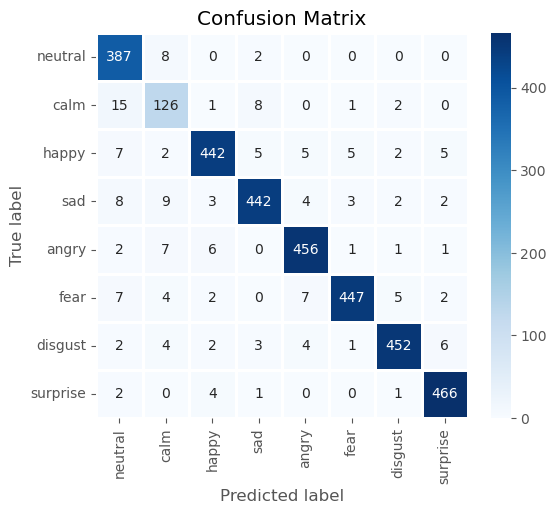

In [21]:
plot_confusion_matrix(y_test, y_pred)

### Classification report

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94       397
           1       0.79      0.82      0.81       153
           2       0.96      0.93      0.95       473
           3       0.96      0.93      0.95       473
           4       0.96      0.96      0.96       474
           5       0.98      0.94      0.96       474
           6       0.97      0.95      0.96       474
           7       0.97      0.98      0.97       474

    accuracy                           0.95      3392
   macro avg       0.93      0.94      0.94      3392
weighted avg       0.95      0.95      0.95      3392

